## Data Analysis of Piecewise Polynomial Solutions

This notebook contains code used to analyse the solutions of piecewise polynomial system of Theorem 1 in the paper, which yields the equilibrium for given market conditions, $p_{min}$, and $p_{max}$.

### Reading the data and preprocessing

The following code is used to read and organize the data to make the analysis process more straightforward.

In [105]:
#install.packages("data.table")
require(data.table)
#install.packages("pillar",type="binary",dependencies=TRUE)
#install.packages('ggplot2',type="binary",dependencies=TRUE)
#install.packages("plyr",type="binary",dependencies=TRUE)
#install.packages("latex2exp",type="binary",dependencies=TRUE)
#install.packages("ggpubr",type="binary",dependencies=TRUE)
#install.packages("grDevices",type="binary",dependencies=TRUE)
#install.packages("forcats",type="binary",dependencies=TRUE)
#install.packages("hms",type="binary",dependencies=TRUE)
#devtools::install_github("EmilHvitfeldt/paletteer",type="binary",dependencies=TRUE,force=TRUE)

require(plyr)
require(latex2exp)
require(paletteer)
require(grDevices)
require(ggpubr)
require(ggplot2)

#Derive all relevant file names for reading purposes:
files=list.files("..//Submission Code and Data/Submission Polynomial Results//Increment005new/",full.names = TRUE)
#Create a list to store the file names
datlist=list()
ct=1
#Read all related files and store in the list named datlist
for (i in files)
{
  datlist[[i]]=fread(i)
  ct=ct+1
}
#Combine all data in a single data table called dat
dat=rbindlist(datlist)
#Give the columns meaningful names
names(dat)=c("surplus", "profit", "welfare","revenue","omegamin", "omegamax", "NB", "NSmin",
"NS", "pminn", "pmaxx", "lb", "ls", "mb", "ms", "eps")
#Additional data naming and filtering
dat[,':='(pminn=round(pminn,2),pmaxx=round(pmaxx,2),eps=round(eps,2))]
dat[,Type:="Semi-centralized"]
dat[pminn==pmaxx,Type:="Centralized"]
dat[pminn==0 & pmaxx==1+eps,Type:="Decentralized"]
dat=dat[eps==0 & !duplicated(dat)]
dat[,NB:=(omegamax-omegamin)*lb/mb]
##Display the first 6 rows
head(dat)

surplus,profit,welfare,revenue,omegamin,omegamax,NB,NSmin,NS,pminn,pmaxx,lb,ls,mb,ms,eps,Type
0.0002375426,1.250487e-05,0.0002500475,2.500974e-05,0.04901,0.9995049,95.04949,0,0.0005006214,0.05,0.05,1,0.01,0.01,0.01,0,Centralized
0.0004500352,5.000944e-05,0.0005000446,1.000189e-04,0.09901,0.9990099,89.99999,0,0.0010012013,0.10,0.10,1,0.01,0.01,0.01,0,Centralized
0.0006375278,1.125137e-04,0.0007500415,2.250273e-04,0.14901,0.9985149,84.95049,0,0.0015018502,0.15,0.15,1,0.01,0.01,0.01,0,Centralized
0.0008000204,2.000175e-04,0.0010000379,4.000350e-04,0.19901,0.9980199,79.90099,0,0.0020025813,0.20,0.20,1,0.01,0.01,0.01,0,Centralized
0.0009375130,3.125208e-04,0.0012500338,6.250416e-04,0.24901,0.9975249,74.85149,0,0.0025034111,0.25,0.25,1,0.01,0.01,0.01,0,Centralized
0.0010500057,4.500235e-04,0.0015000292,9.000471e-04,0.29901,0.9970299,69.80199,0,0.0030043611,0.30,0.30,1,0.01,0.01,0.01,0,Centralized


Note that for computational efficiency, we did not need to find solutions for $p_{min}$ and $p_{max}$ values that we knew would yield the same equilibrium solutions. To explain this, suppose we fix the $p_{min}$ value and the market conditions. Let the highest cost that enters the market under any $p_{max}$, $\tilde{c}(p_{max})$. We know that $\tilde{c}(p_{max})$ is non-decreasing in $p_{max}$. Therefore, we know that for any $p_{max}>\tilde{c}(1+\epsilon)$, we have the same equilibrium. Leveraging this fact, we did not explicitly solve the piecewise polynomial system for such $p_{max}$ values that yield the same equilibrium. In the next chunk of code, we fill in the data for such $p_{max}$ values.

In [97]:
##Set the increment used in discretizing p_min and p_max
inc=0.05

pcl_up=dat[Type=="Semi-centralized" & pmaxx!=1+eps,.(pcl=ifelse(min(pmaxx)-inc<pminn,pminn,min(pmaxx)-inc),p_up=ifelse(max(pmaxx)+inc>1+eps,1+eps,max(pmaxx)+inc)),.(mb,ms,lb,ls,eps,pminn)]
pcl_up[,`:=`(pcl=round(pcl,2),p_up=round(p_up,2))]
pcl_up_merged=merge(dat,pcl_up,all.x=TRUE)
pcl_up_merged[is.na(pcl),pcl:=pminn]
pcl_up_merged[is.na(p_up),p_up:=ifelse(pminn+inc>1+eps,1+eps,pminn+inc)]

datcent=dat[Type=='Centralized',.(mu_b=mb,mu_s=ms,lambda_b=lb,lambda_s=ls,p_min=pminn,p_max=pmaxx,epsilon=eps,welfare,revenue,NB,NS)]
datcent=datcent[,.(welfare=welfare[1],revenue=revenue[1],NB=NB[1],NS=NS[1]),.(mu_b,mu_s,lambda_b,lambda_s,epsilon,p_min,p_max)][order(-p_max)]

##Retrieve the complete data
#fill from p_up to 1+eps decentralized
pcl_up_upfill=pcl_up_merged[,.(pmaxx=seq(1+eps,unique(p_up),-inc),welfare=welfare[pmaxx==1+eps],revenue=revenue[pmaxx==1+eps],NB=NB[pmaxx==1+eps],NS=NS[pmaxx==1+eps]),.(mb,ms,lb,ls,eps,pminn)]
#fill from pcl to pmin centralized
pcl_up_downfill=pcl_up_merged[,.(pmaxx=seq(unique(pcl),pminn,-inc)[seq(unique(pcl),pminn,-inc)!=0],
  welfare=datcent[p_max %in% round(seq(unique(pcl),pminn,-inc),2) & p_min==p_max &
            mu_b==mb & mu_s==ms & lambda_b==lb & lambda_s==ls & epsilon==eps,welfare],
  revenue=datcent[p_max %in% round(seq(unique(pcl),pminn,-inc),2) & p_min==p_max &
                    mu_b==mb & mu_s==ms & lambda_b==lb & lambda_s==ls & epsilon==eps,revenue],
  NB=datcent[p_max %in% round(seq(unique(pcl),pminn,-inc),2) & p_min==p_max &
                    mu_b==mb & mu_s==ms & lambda_b==lb & lambda_s==ls & epsilon==eps,NB],  
  NS=datcent[p_max %in% round(seq(unique(pcl),pminn,-inc),2) & p_min==p_max &
                    mu_b==mb & mu_s==ms & lambda_b==lb & lambda_s==ls & epsilon==eps,NS]),.(mb,ms,lb,ls,eps,pminn)]

pcl_up_upfill[,`:=`(pminn=round(pminn,2),pmaxx=round(pmaxx,2))]
pcl_up_downfill[,`:=`(pminn=round(pminn,2),pmaxx=round(pmaxx,2))]
dat[,`:=`(pminn=round(pminn,2),pmaxx=round(pmaxx,2))]

alldat=rbind(dat[,.(mb,ms,lb,ls,eps,pminn,pmaxx,welfare,revenue,NB,NS)],pcl_up_upfill,pcl_up_downfill)
alldat=alldat[!duplicated(alldat)]

### Creating figures in the paper
We start by creating the Figure 3 and 4 in the paper. To this end, we first create the data needed to make this comparison. Namely, we derive the rows with $p_{min}=0$ and find the $p_{max}$ values that yield the maximum welfare for every market condition. Similarly, we extract the rows for the centralized platforms and find the centralized price that maximizes welfare for every market condition. We also extract rows for the decentralized platform.

In [100]:
##derive the centralized and semi-centralized data
decentralized_data=alldat[pminn==0 & pmaxx==1+eps,.(welfare),.(mb,ms,lb,ls,eps)]
centralized_data=alldat[pminn==pmaxx,.SD[welfare==max(welfare),.(welfare,pminn,pmaxx)],.(mb,ms,lb,ls,eps)]
centralized_data_revmax=alldat[pminn==pmaxx,.SD[revenue==max(revenue,na.rm=T),.(revenue,welfare,pminn,pmaxx)],.(mb,ms,lb,ls,eps)]
best_pmax_data=alldat[pminn==0,.SD[welfare==max(welfare),.(welfare,pmaxx)],.(mb,ms,lb,ls,eps)]
##set names to distinguish platform types
setnames(decentralized_data,"welfare","welfare_decentralized")
setnames(centralized_data,"welfare","welfare_centralized")
setnames(centralized_data_revmax,"welfare","welfare_centralized_revmax")
setnames(best_pmax_data,"welfare","welfare_pmaxbest")


We first create the Figure 3.

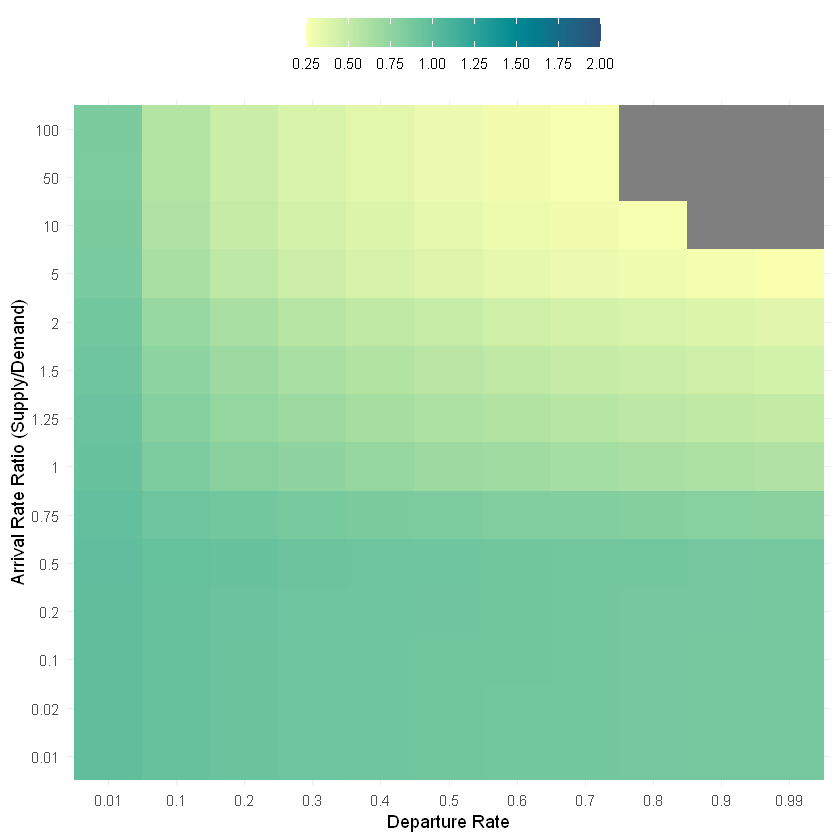

In [102]:
##merge the centralized and the decentralized data for comparison
fig3_a_data=merge(centralized_data,decentralized_data,c("mb","ms","lb","ls","eps"))
##Plot
ggplot(fig3_a_data,aes(x=as.factor(mb),y=as.factor(ls),fill=welfare_decentralized/welfare_centralized))+
  geom_tile()+theme_minimal()+
  labs(color="Welfare Ratio",x='Departure Rate',
        y="Arrival Rate Ratio (Supply/Demand)",fill="")+
  theme(axis.title.y=element_text(size=11),axis.title.x=element_text(size=11),legend.key.width =unit(1.25,'cm'))+
  scale_fill_paletteer_c(palette ="grDevices::BluYl",limits=c(0.25,2),breaks=c(0.25,0.5,0.75,1,1.25,1.5,1.75,2),direction=-1)+
  theme(legend.position="top")

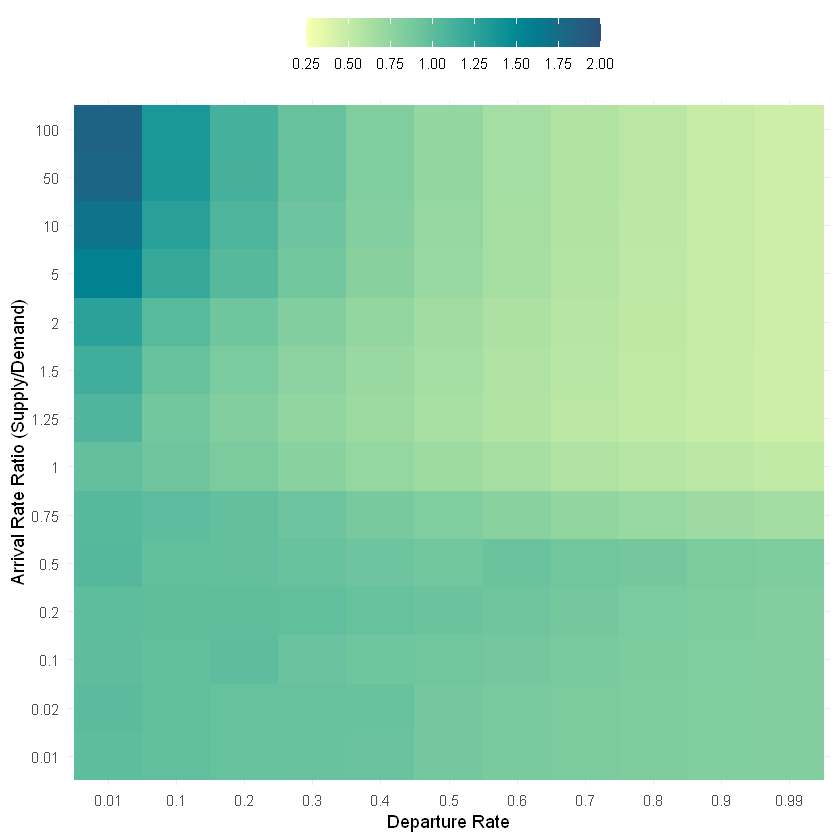

In [104]:
##merge the centralized and the decentralized data for comparison
fig3_b_data=merge(centralized_data_revmax,decentralized_data,c("mb","ms","lb","ls","eps"))
##Plot
ggplot(fig3_b_data,aes(x=as.factor(mb),y=as.factor(ls),
                       fill=welfare_decentralized/welfare_centralized_revmax))+
  geom_tile()+theme_minimal()+labs(color="Welfare Ratio",x='Departure Rate',
        y="Arrival Rate Ratio (Supply/Demand)",fill="")+
  theme(axis.title.y=element_text(size=11),axis.title.x=element_text(size=11),
        legend.key.width =unit(1.25,'cm'))+
  scale_fill_paletteer_c(palette ="grDevices::BluYl",limits=c(0.25,2.0),
                         breaks=c(0.25,0.5,0.75,1,1.25,1.5,1.75,2),direction=-1)+
    theme(legend.position="top")

Next, we create Figure 4-b. To this end, we first derive the minimum and the maximum prices for the decentralized platform for every market condition in the first cell below, then create the plot in the next cell.

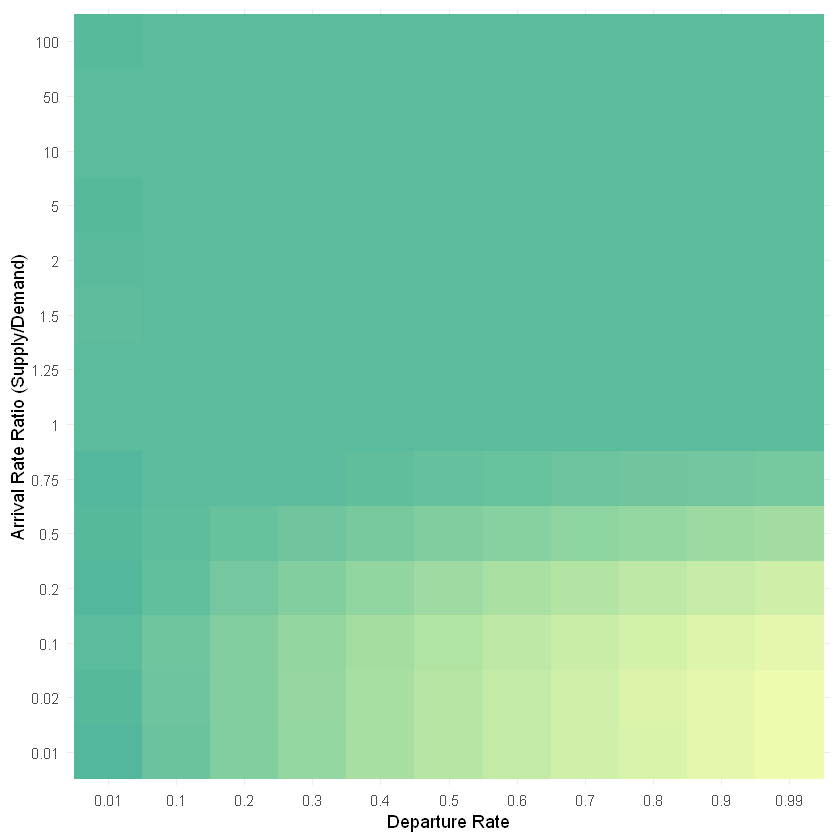

In [66]:
##merge the two
fig4_a_data=merge(centralized_data,best_pmax_data,c("mb","ms","lb","ls","eps"))
##Plot
(onlyplot=ggplot(fig4_a_data,aes(x=as.factor(mb),y=as.factor(ls),fill=welfare_pmaxbest/welfare_centralized))+
  geom_tile()+theme_minimal()+
  labs(color="Welfare Ratio",x='Departure Rate',
        y="Arrival Rate Ratio (Supply/Demand)",fill="")+
  theme(axis.title.y=element_text(size=11),axis.title.x=element_text(size=11),legend.key.width =unit(1.25,'cm'))+
  scale_fill_paletteer_c(palette ="grDevices::BluYl",limits=c(0.5,1.65),breaks=c(0.25,0.5,0.75,1,1.25,1.5,1.75,2),direction=-1)+
  theme(legend.position="none"))

In [86]:
##Derive maximum and minimum prices for the decentralized platform for every market condition
decentralized_data=dat[Type=="Decentralized",list(max_price=unique(omegamax),
                                                  min_price=unique(omegamin)),.(lb,ls,mb,ms,Type)]
centralized_data[,Type:="Centralized"]
setnames(centralized_data,c("pminn","pmaxx"),c("min_price","max_price"))
pricedata=rbind(decentralized_data,centralized_data[,-c("welfare_centralized","eps")])
#a sample from the data
head(pricedata)

lb,ls,mb,ms,Type,max_price,min_price
1,0.01,0.01,0.01,Decentralized,0.9903109,0.9786094
1,0.01,0.10,0.10,Decentralized,0.9919006,0.8999186
1,0.01,0.20,0.20,Decentralized,0.9933906,0.8261629
1,0.01,0.30,0.30,Decentralized,0.9946549,0.7635830
1,0.01,0.40,0.40,Decentralized,0.9957411,0.7098166
1,0.01,0.50,0.50,Decentralized,0.9966844,0.6631239


Warning message:
"position_dodge requires non-overlapping x intervals"

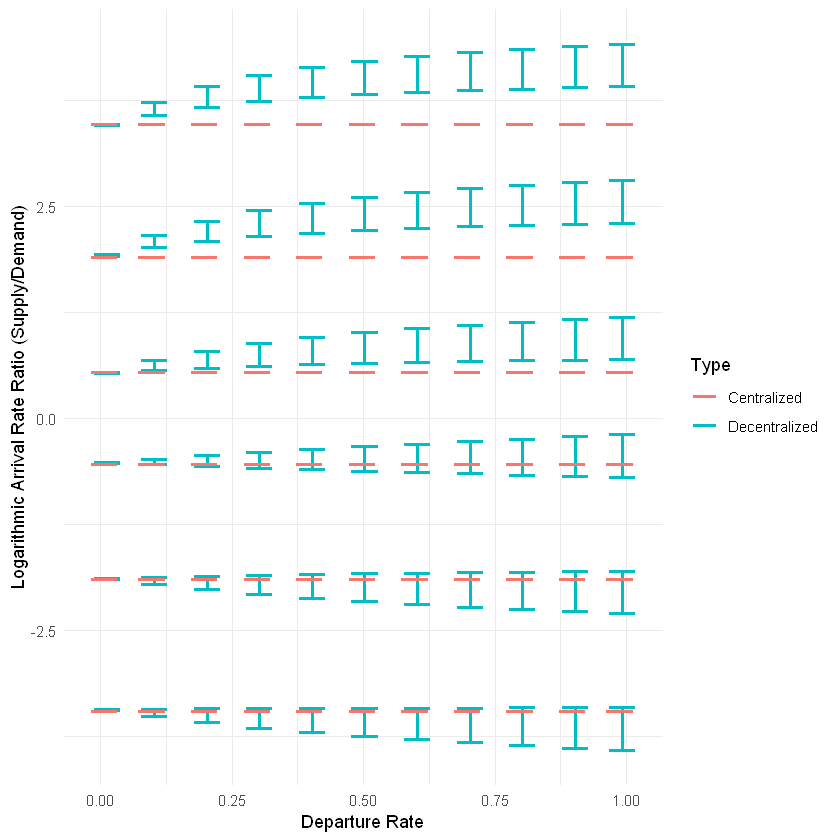

In [87]:
ggplot(pricedata[(lb/ls) %in% c(0.02,0.1,0.5,2,10,50)],aes(y=log(ls/lb),x=ms))+
  geom_errorbar(aes(ymin=log(ls/lb)+min_price-0.5,
                    ymax=log(ls/lb)+max_price-0.5,color=Type),position = position_dodge(0.01),
                width=0.1,size=1)+
  labs(x='Departure Rate',
       y="Logarithmic Arrival Rate Ratio (Supply/Demand)")+theme_minimal()


Given this data, we create Figure 6 in the paper.

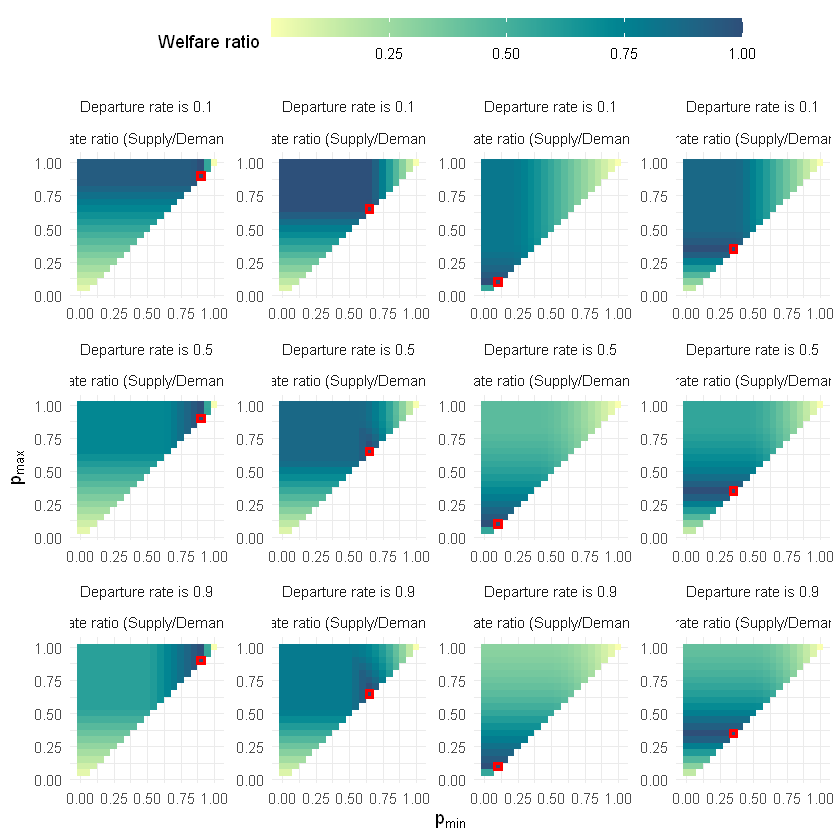

In [99]:

# Compute the welfare ratio for each combination of mb, ms, lb, ls, and eps
alldat[, welfare_ratio := welfare / max(welfare), by = .(mb, ms, lb, ls, eps)]

# Select the market conditions of interest
pminmax = alldat[mb %in% c(0.1, 0.5, 0.9) & ls %in% c(0.1, 0.5, 2, 10) & eps==0]

# Convert ls and ms to factors with custom labels
pminmax$ls = factor(pminmax$ls,
                    levels = unique(pminmax$ls),
                    labels = paste('Arrival rate ratio (Supply/Demand) is', unique(pminmax$ls)))
pminmax$ms = factor(pminmax$ms,
                    levels = unique(pminmax$ms),
                    labels = paste('Departure rate is', unique(pminmax$ms)))

# Create a tile plot with rectangles highlighting max welfare ratios
ggplot() +

# add a tile layer to the plot with the data specified and mapping x, y, and fill aesthetics
geom_tile(data=pminmax, aes(x=pminn, y=pmaxx, fill=welfare_ratio)) +

# add a rectangular layer to highlight the highest welfare ratio for each combination of market conditions
geom_rect(data=pminmax[pminn==pmaxx,.SD[welfare_ratio==max(welfare_ratio)],.(ls,mb)],
          aes(xmin=pminn-0.025, xmax=pminn+0.025, ymin=pmaxx-0.025, ymax=pmaxx+0.025),
          fill=NA, color="red", size=1) +

# set the color palette for the fill aesthetic and customize the scale
scale_fill_paletteer_c(palette="grDevices::BluYl", limits=c(0,1),
                       breaks=c(0.25,0.5,0.75,1), direction=-1) +

# wrap the plot into a grid of facets based on levels of ms and ls variables, and set the row number for each facet to be 3
facet_wrap(~ms+ls, nrow=3, scale="free") +

# customize the theme to minimal style, add axis labels, and fill legend title
theme_minimal() + labs(x=TeX("$\\p_{min}$"), y=TeX("$\\p_{max}$"), fill='Welfare ratio') +

# further customize the theme to adjust legend and axis title sizes, legend key width and height
theme(legend.position='top', axis.title.y=element_text(size=11),
      axis.title.x=element_text(size=11), legend.key.width=unit(2,'cm'),
      legend.key.height=unit(0.4,'cm'))



Next, we create the Figure 7 in the paper.

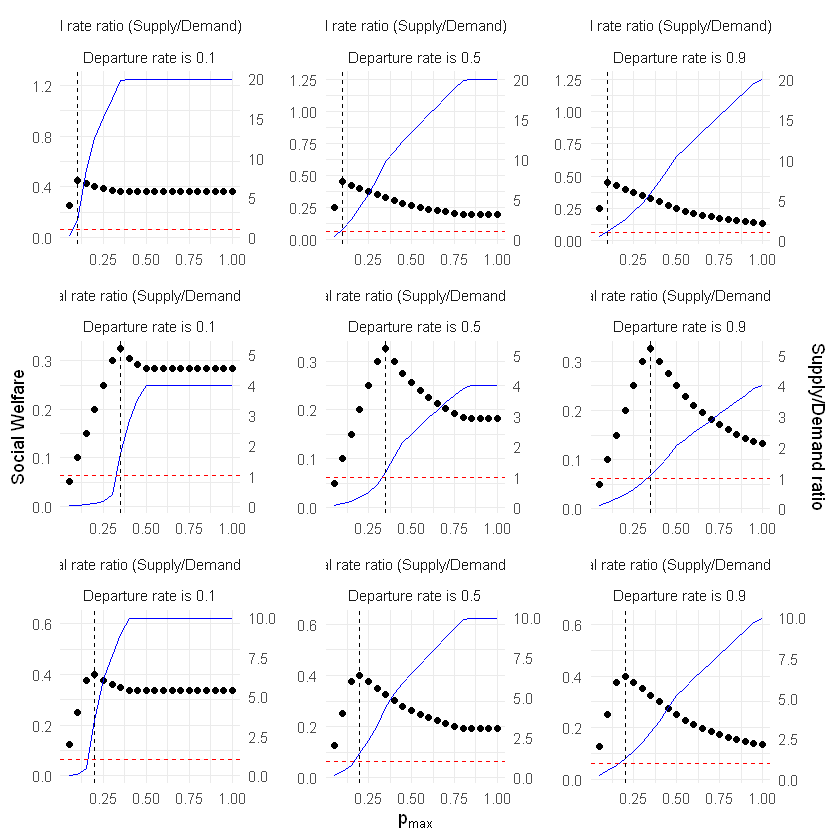

In [72]:
# filter the data to obtain only the data of interest
datofinterest <- alldat[pminn == 0 & mb %in% c(0.1, 0.5, 0.9) & ls %in% c(2, 5, 10)]

# update the factors to use meaningful labels
datofinterest$ls <- factor(datofinterest$ls, levels = unique(datofinterest$ls),
                           labels = paste('Arrival rate ratio (Supply/Demand) is', unique(datofinterest$ls)))
datofinterest$mb <- factor(datofinterest$mb, levels = unique(datofinterest$mb),
                           labels = paste('Departure rate is', unique(datofinterest$mb)))

# create a plot of welfare versus pmax, with various additional elements
ggplot(data = datofinterest[order(ls)], aes(x = pmaxx)) +
  # plot welfare as points
  geom_point(aes(y = welfare)) +
  # plot a scaled version of NS/NB as a blue line
  geom_line(aes(y = NS / NB / 16), color = "blue") +
  # add a horizontal line to indicate where supply and demand are equal to each other
  geom_hline(aes(yintercept = 1 / 16), color = 'red', linetype = 'dashed') +
  # add a vertical line for the value of pmaxx that gives maximum welfare
  geom_vline(data = datofinterest[,.SD[welfare == max(welfare), .(pmaxx)], .(ls, mb)],
             aes(xintercept = pmaxx, group = 1), color = 'black', linetype = 'dashed') +
  # add a secondary y-axis with a label
  scale_y_continuous(name = "Social Welfare", sec.axis = sec_axis(~.*16, name = "Supply/Demand ratio")) +
  # create a facet plot for each combination of ls and mb
  facet_wrap(~ls + mb, scale = 'free') +
  # customize the theme of the plot
  theme_minimal() +
  labs(x = TeX("$\\p_{max}$")) 
